In [20]:
from DMXEnttecPro import Controller
import numpy as np
import time
from matplotlib import pyplot as plt
import datetime
import os
import luxpy as lx  # package for color science calculations
from luxpy.toolboxes import spectro as sp
import glob
# port = get_port_by_serial_number('EN279626')
# dmx = Controller(port, dmx_size=256)
cieobs = '1964_10'
try:
    dmx = Controller('COM5')
    sp.init('jeti')
except:
    dmx = None
    print('no connection')

def dmx_render(r,g,b,w,a,uv=0):
    dmx.set_channel(1, int(r))
    dmx.set_channel(2, int(g))
    dmx.set_channel(3, int(b))
    dmx.set_channel(4, int(w))
    dmx.set_channel(5, int(a))
    dmx.set_channel(6, int(uv))
    dmx.submit()
is_plot = False

In [22]:
if dmx is not None:
    sp.jeti.set_laser(laser_on=True)
    dmx_render(0,0,0,0,0)
    time.sleep(0.5)
    sp.jeti.set_laser(laser_on=False)


In [50]:
def calibrate(filename=None):
    if filename is None:
        assert dmx is not None
        now = datetime.datetime.now()
        filename = './output/data_' + now.strftime('%Y%m%d_%H%M%S')
        if not os.path.exists(os.path.dirname(filename)):
            os.mkdir(os.path.dirname(filename))
        
        channels = [1, 2, 3, 4, 5]

        output_values = np.arange(0, 256, 10)
        # print(np.concatenate([np.arange(0, 20, 2), np.arange(20, 255, 10)]))
        # output_values = np.concatenate([np.arange(0, 20, 2), np.arange(20, 255, 40)])

        if output_values[-1] < 255:  # make sure the last output is max.
            output_values = np.append(output_values, 255)

        measured_spd_all = []
        measured_luminance_all = []

        for channel in channels:
            measured_spd = []
            measured_luminance = []
            for c in channels:
                dmx.set_channel(c, 0)
                dmx.submit()

            for v in output_values:
                print(channel, v)
                if dmx is not None:
                    dmx.set_channel(channel, v)
                    dmx.submit()
                    time.sleep(0.2)
                if v <= 0:
                    measured_luminance.append(0)
                    measured_spd.append(None)
                else:
                    spd = sp.jeti.get_spd(autoTint_max=3)
                    l = lx.spd_to_power(spd, ptype='pu', cieobs='1964_10')
                    measured_luminance.append(l[0][0])
                    measured_spd.append(spd)

            if measured_spd[0] is None:
                measured_spd[0] = measured_spd[1].copy()
                measured_spd[0][-1] = measured_spd[0][-1]*0
                
            print(measured_luminance)

            measured_spd_all.append(measured_spd)
            measured_luminance_all.append(measured_luminance)
        np.savez(filename, luminance=measured_luminance_all,
                spd=measured_spd_all, output_values=output_values, channels=channels)
        return np.load(filename+'.npz')
    return np.load(filename)
           

      

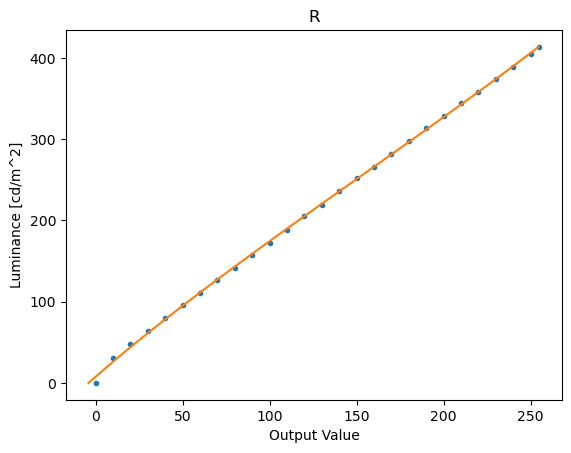

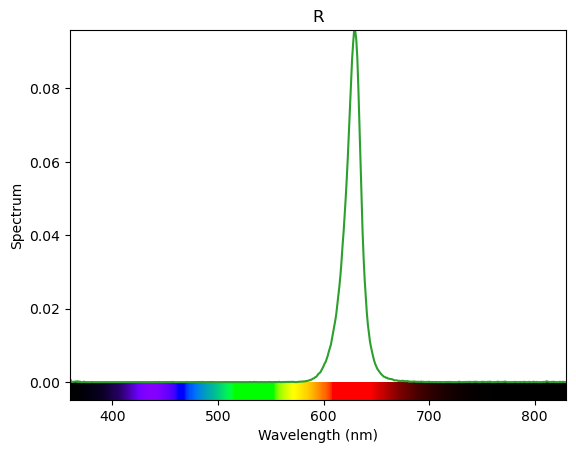

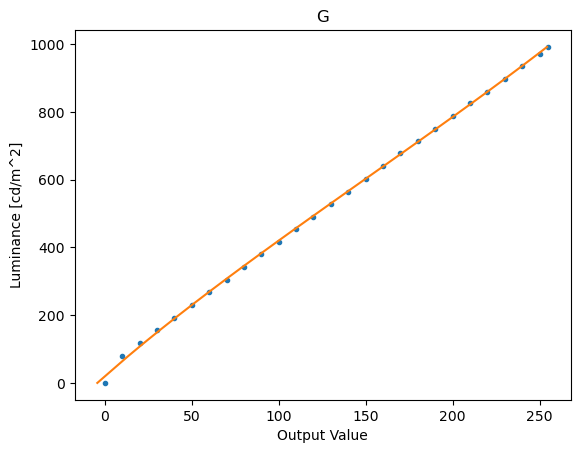

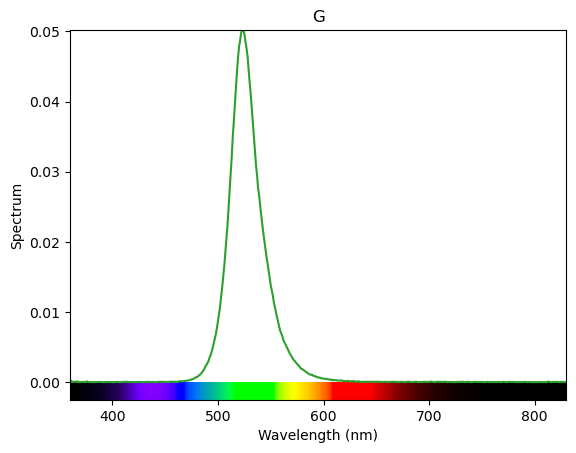

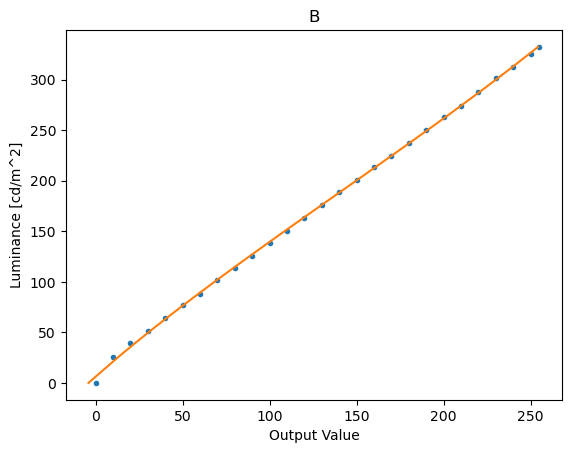

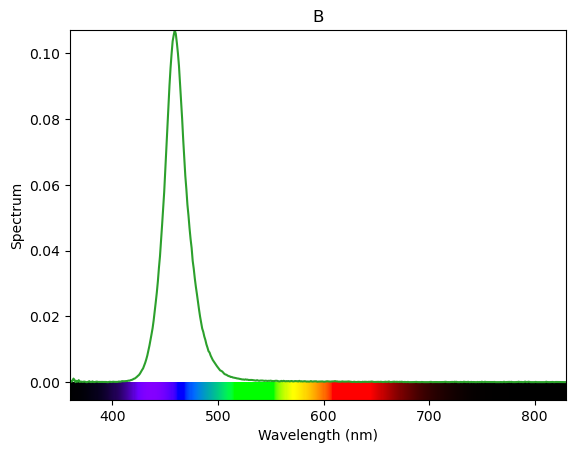

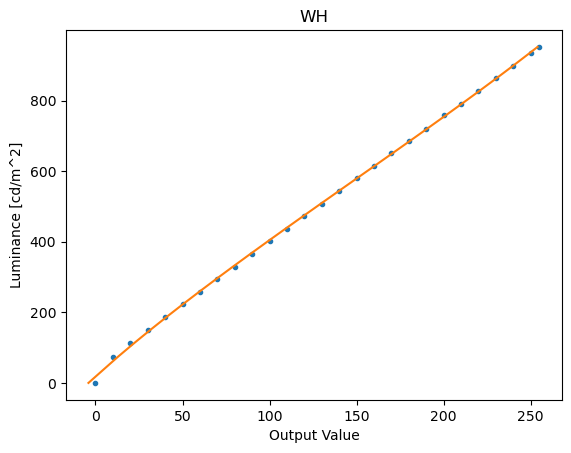

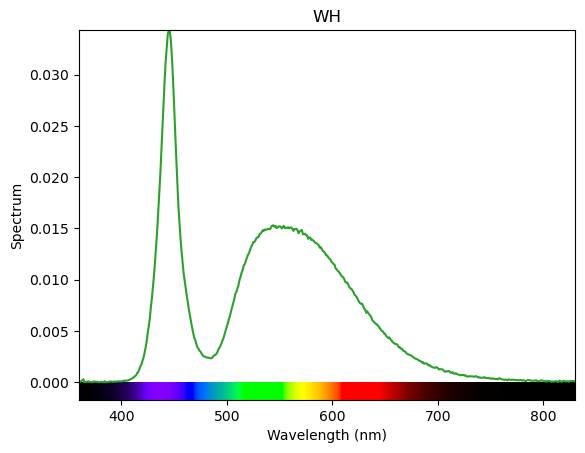

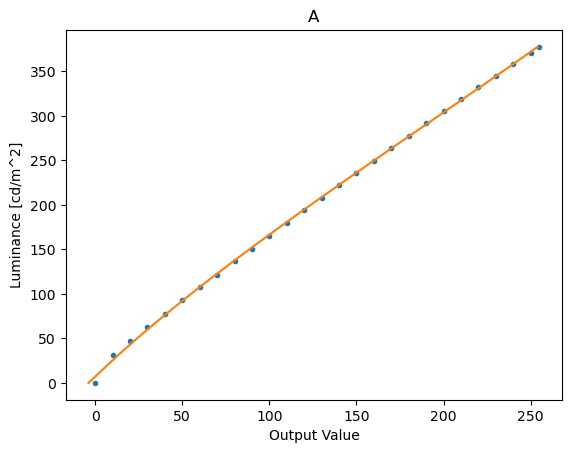

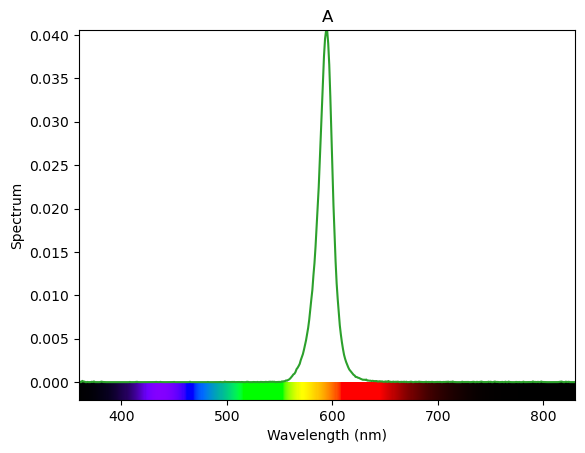

In [58]:
f = 'output/data_20230324_163716.npz'
f = 'output/data_20230420_104200.npz'
# f=None
is_plot = True
data = calibrate(f)
output_values = data['output_values']
channels = data['channels']
measured_luminance_all = data['luminance']
measured_spd_all = data['spd']

labels = ['R', 'G', 'B', 'WH', 'A', 'UV']

normL2output = []

for i, channel in enumerate(channels):
    luminance = np.asarray(measured_luminance_all[i])
    spd = measured_spd_all[i]
    luminance = luminance - measured_luminance_all[i][0]
    # normalized_luminance = (luminance-min(luminance)) / (max(luminance)-min(luminance))
    normalized_luminance = luminance / max(luminance)

    z = np.polyfit(luminance, output_values,3)
    z_norm = np.polyfit(normalized_luminance, output_values,3)

    func = np.poly1d(z)
    func_norm = np.poly1d(z_norm)
    normL2output.append(func_norm)

    if is_plot:
        plt.figure()
        plt.plot(output_values, luminance, '.')
        plt.plot(func(luminance), luminance, '-')
        plt.xlabel('Output Value')
        plt.ylabel('Luminance [cd/m^2]')
        plt.title(labels[i])
        plt.savefig('output/luminance_output_{}.png'.format(labels[i]))

        plt.figure()
        plt.plot(output_values, normalized_luminance, '.')
        plt.plot(func_norm(normalized_luminance), normalized_luminance, '-')
        plt.xlabel('Output Value')
        plt.ylabel('Normalized Luminance')
        plt.title(labels[i])
        plt.savefig('output/normL_output_{}.png'.format(labels[i]))

        lx.SPD(spd[-1]).plot()
        plt.title(labels[i])
        plt.savefig('output/spd_255_{}.png'.format(labels[i]))


## 3-channels color mixing

Estimated primary contributions (3, xyz): [[7.5561e-02 6.8975e-02 3.0908e-02]]
Output values of the light source: [1.3000e+01 1.1000e+01 3.0000e+00]
1 13
2 11
3 3


SerialException: WriteFile failed (PermissionError(13, 'Access is denied.', None, 5))

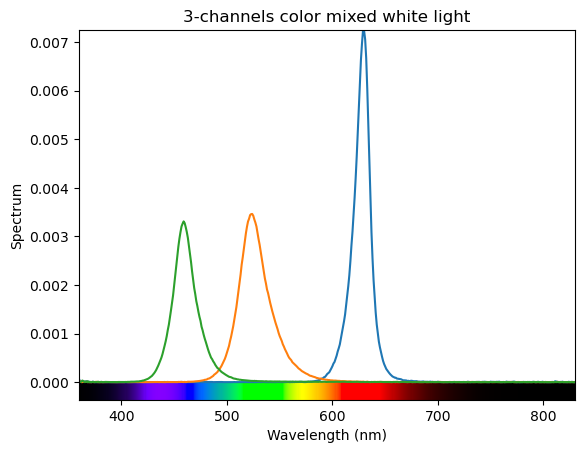

In [75]:
from luxpy.toolboxes import spdbuild as spb

def getPrimarySPD(channels_idx):
    spd_p = []
    for c in channels_idx:
        spd = measured_spd_all[c][-1].copy()
        # spd[-1] = spd[-1] - measured_spd_all[c][0][-1]
        spd_p.append(spd)
    return np.vstack([spd_p[0][0]] +
                         [s[-1] for s in spd_p])

def color_mixing(xyz_t, Yxy_t, channels_idx):
                
    spd_p3 = getPrimarySPD(channels_idx=channels_idx)
    xyz_p3 = lx.spd_to_xyz(spd_p3, relative=False)
    Yxy_p3 = lx.xyz_to_Yxy(xyz_p3)

    M_xyz3 = spb.colormixer_pinv(xyz_t, xyz_p3, input_fmt='xyz') 
    M_Yxy3 = spb.colormixer_pinv(Yxy_t,Yxy_p3,input_fmt='Yxy')

    weighted_p3 = spd_p3.copy()
    for i, (p, w) in enumerate(zip(weighted_p3[1:], M_xyz3[0])):
        weighted_p3[i+1] = p*w

    lx.SPD(weighted_p3).plot()
    plt.title('3-channels color mixed white light')
    plt.savefig('3channels_color_mixing')

    output = []
    for i, w in zip(channels_idx, M_xyz3[0]):
        v = normL2output[i](w)
        output.append(v)
    output = np.around(output)

    # print('primary color xyz is', xyz_p3)
    print('Estimated primary contributions (3, xyz):', M_xyz3)
    print('Output values of the light source:', output)

    if dmx is not None:
        for i, v in zip(channels_idx, output):
            dmx.set_channel(i+1, int(v)) # light source's channels start from 1
            print(i+1, int(v))
        dmx.submit()
        time.sleep(1)
        spd = sp.jeti.get_spd()
        l = lx.spd_to_power(spd, ptype='pu', cieobs=cieobs)
        
        xyz_measured = lx.spd_to_xyz(spd, relative=False)
        Yuv_measured = lx.xyz_to_Yuv(xyz_measured)
        Yuv_target = lx.xyz_to_Yuv(xyz_t)

        print(l, xyz_measured)
        
        Y_t, u_t, v_t = lx.utils.asplit(Yuv_target)
        Y, u, v = lx.utils.asplit(Yuv_measured)
        ax = plt.figure().add_subplot(111)
        ax.plot(u, v,\
            color ='r',marker = 'o', linestyle = 'none', label='measured')
        ax.plot(u_t, v_t, \
            color ='b',marker ='d', linestyle = 'none', label='target')
        ax.set_xlabel("u'") # set x-axis label
        ax.set_ylabel("v'") # set y-axis label
        lx.plotSL(cieobs=cieobs, cspace='Yuv', DL=True,
            BBL=True, diagram_colors=True, axh=ax)


xyz_t = np.array([[100, 100, 100]])*1
Yxy_t = np.array([[100, 1/3.0, 1/3.0]])
channels_idx = [0, 1, 2]
color_mixing(xyz_t, Yxy_t, channels_idx)




## 4-channels colormixing

Estimated primary contributions (3, xyz): [[5.4309e-02 6.2389e-02 3.1125e-02 3.9476e-02]]
Output values of the light source: [8.0000e+00 9.0000e+00 3.0000e+00 4.0000e+00]
1 8
2 9
3 3
5 4
[[1.3865e+02]] [[1.2637e+02 1.2609e+02 1.3589e+02]]


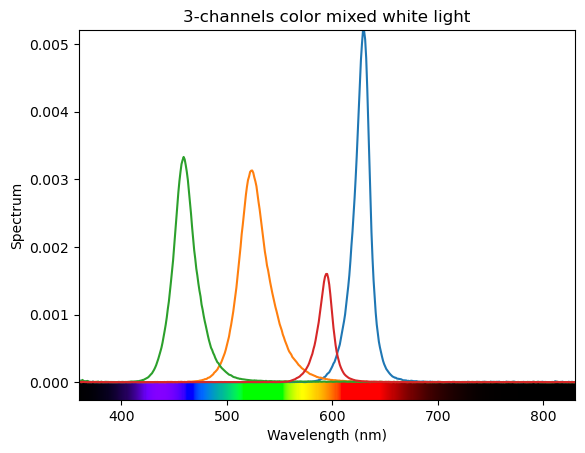

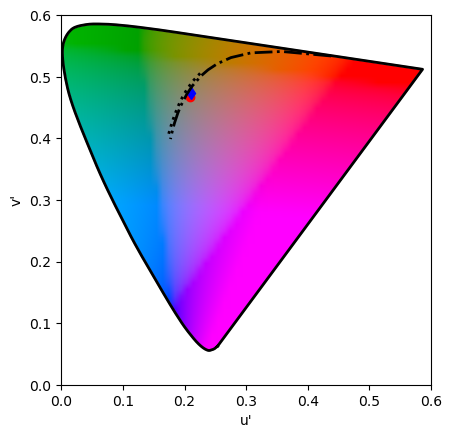

In [65]:
xyz_t = np.array([[100, 100, 100]])*1
Yxy_t = np.array([[100, 1/3.0, 1/3.0]])
channels_idx = [0, 1, 2, 4]
color_mixing(xyz_t, Yxy_t, channels_idx)


### Multi-objective optimizer


Results (optim,target):
Yxy: ([100,0.33,0.33],[200,0.33,0.33])
Rf: (84.40,90.00)
Rg: (105.54, 110.00)
cct(K), duv: (5482.0,-0.0041)

Flux ratios of component spectra: [[3.1530e-02 5.0997e-02 2.9988e-02 6.9999e-02]]


<AxesSubplot:xlabel='Wavelength (nm)', ylabel='Spectrum'>

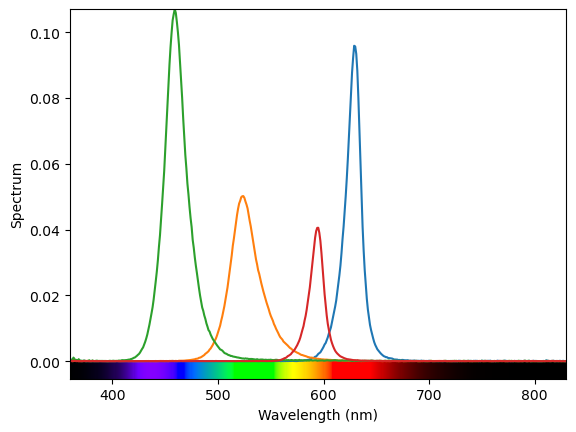

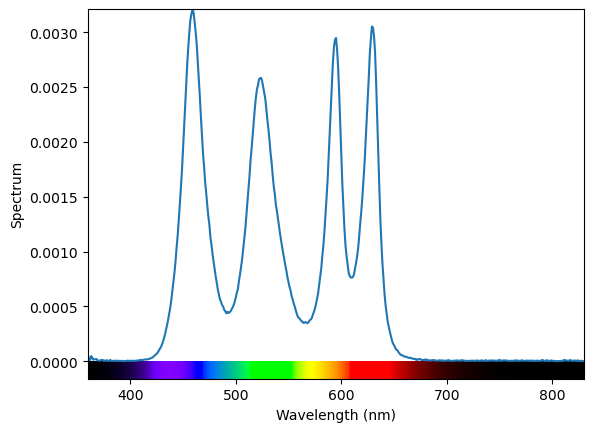

In [78]:
target = np.array([[200, 1/3, 1/3]])
xyz_t = np.array([[100, 100, 100]])*1
channels_idx = [0, 1, 2, 4]

# define function that calculates several objectives at the same time (for speed):
def spd_to_cris(spd):
    Rf, Rg = lx.cri.spd_to_cri(spd, cri_type='ies-tm30', out='Rf,Rg')
    return np.vstack((Rf, Rg))

obj_fcn = [(spd_to_cris, 'Rf', 'Rg')]
obj_tar_vals = [(90, 110)]

# create set of 4 primaries with fixed peakwl and fwhm bounds set to [5,100]:
prims2 = spb.PrimConstructor(pdefs={'peakwl':[450,520,580,630],
                                'fwhm_bnds':[5,100]}).get_spd()
spd_p3 = getPrimarySPD(channels_idx=channels_idx)
xyz_p3 = lx.spd_to_xyz(spd_p3, relative=False)

lx.SPD(spd_p3).plot()

# Initialize SpectralOptimizer object:
so3 = spb.SpectralOptimizer(target=xyz_t, tar_type='xyz', cspace_bwtf={},
                            wlr=[360, 830, 1], cieobs=cieobs,
                            out='spds,primss,Ms,results',
                            optimizer_type='3mixer', triangle_strengths_bnds=None,
                            prim_constructor=None,
                            prims=spd_p3,
                            obj_fcn=spb.ObjFcns(f=obj_fcn, ft=obj_tar_vals),
                            minimizer=spb.Minimizer(method='Nelder-Mead'),
                            verbosity=0)

# start optimization:
S, M = so3.start(out='spds,Ms')

# Check output agrees with target:
xyz = lx.spd_to_xyz(S, relative=False, cieobs=cieobs)
Yxy = lx.xyz_to_Yxy(xyz)
cct, duv = lx.xyz_to_cct(xyz, cieobs=cieobs, out='cct,duv')
Rf, Rg = spd_to_cris(S)
print('\nResults (optim,target):')
print("Yxy: ([{:1.0f},{:1.2f},{:1.2f}],[{:1.0f},{:1.2f},{:1.2f}])".format(
    Yxy[0, 0], Yxy[0, 1], Yxy[0, 2], target[0, 0], target[0, 1], target[0, 2]))
print("Rf: ({:1.2f},{:1.2f})".format(Rf[0], obj_tar_vals[0][0]))
print("Rg: ({:1.2f}, {:1.2f})".format(Rg[0], obj_tar_vals[0][1]))
print("cct(K), duv: ({:1.1f},{:1.4f})".format(cct[0, 0], duv[0, 0]))

print('\nFlux ratios of component spectra:', M)

#plot spd:
plt.figure()
lx.SPD(S).plot()

In [106]:
if dmx is not None:
    dmx.set_channel(1, 0)
    dmx.submit()
    dmx.close()